In [1]:
import logging
import copy
import os
import sys
from functools import reduce
from collections import Counter
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from absa import TEST_APPENDIX, parsed_reviews_dump_path, images_path
from absa.preprocess.dep_parse import load_parsed_reviews
from absa.utils.embedding import get_embeddings
from absa.review.target import Polarity

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
logging.basicConfig(level=logging.INFO)

seed = 42
np.random.seed(seed)

# Upload

### train

In [2]:
train_reviews = load_parsed_reviews(file_pathway=parsed_reviews_dump_path)
train_sentences = [x for x in reduce(lambda x, y: x + y, train_reviews)]

INFO:root:Upload dependency trees from dump.


In [3]:
len(train_sentences)

3655

### test

In [4]:
test_reviews = load_parsed_reviews(file_pathway=parsed_reviews_dump_path + TEST_APPENDIX)
test_sentences = [x for x in reduce(lambda x, y: x + y, test_reviews)]

INFO:root:Upload dependency trees from dump.


In [5]:
len(test_sentences)

1209

In [6]:
sentences = train_sentences

# Sentiment distribution

There is only one 'conflict' polarity

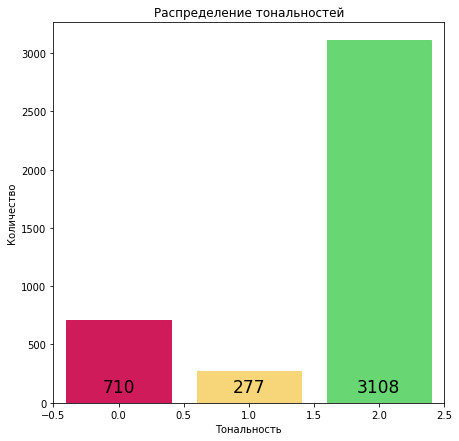

In [18]:
polarity_count = Counter()

for sentence in sentences:
    for target in sentence.targets:
        polarity_count.update([target.polarity])
        
xy = [(x.value, y) for x, y in sorted(polarity_count.items(), key=lambda item: item[0].value)]
x = [i[0] for i in xy]
y = [j[1] for j in xy]
            
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
bar_plot = ax.bar(x, y, color='#0000ff', zorder=5)
bar_plot[Polarity.positive.value].set_color('#67D673')
bar_plot[Polarity.neutral.value].set_color('#F7D579')
bar_plot[Polarity.negative.value].set_color('#CF1B5A')
plt.xlim(left=-0.5, right=2.5)
for i, v in xy:
    ax.text(x=i-0.05*len(str(y[i])) + 0.03, 
            y=90, 
            s=y[i], 
            fontsize=17,
            color='black',
            zorder=10,)
plt.xlabel('Тональность')
plt.ylabel('Количество')
plt.title('Распределение тональностей')
plt.savefig(os.path.join(images_path, 'polarity_distribution.pdf'))

# Aspect categories

In [31]:
all_reviews = train_reviews + test_reviews
aspects = set()

for review in all_reviews:
    for sentence in review:
        for target in sentence.targets:
            aspects.add(target.category)

aspects

{'AMBIENCE#GENERAL',
 'DRINKS#PRICES',
 'DRINKS#QUALITY',
 'DRINKS#STYLE_OPTIONS',
 'FOOD#PRICES',
 'FOOD#QUALITY',
 'FOOD#STYLE_OPTIONS',
 'LOCATION#GENERAL',
 'RESTAURANT#GENERAL',
 'RESTAURANT#MISCELLANEOUS',
 'RESTAURANT#PRICES',
 'SERVICE#GENERAL'}

### Mark one target as different aspects

In [33]:
category_count = Counter()

for sentence in sentences:
    if sentence.targets:
        sentece_cat = [v for n, v in Counter([frozenset(target.nodes) for target in sentence.targets]).items()]
        category_count.update(sentece_cat)
            
category_count

Counter({1: 3874, 2: 106, 3: 3})

### Null targets

In [18]:
none_targets = 0

for review in reviews:
    for sentence in review.sentences:
        for target in sentence.targets:
            if not target.nodes:
                none_targets += 1
                
none_targets

934

## Distributions

### Aspect

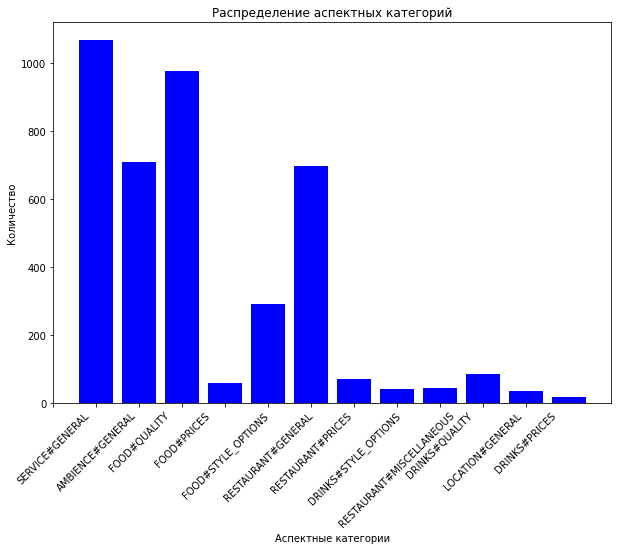

In [41]:
entity_counter = Counter()

for sentence in sentences:
    for target in sentence.targets:
        entity_counter.update([target.category])
           
labels = [x for x in entity_counter.keys()]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
#ax.grid('on', zorder=0)
plt.bar(entity_counter.keys(), entity_counter.values(), color='#0000ff', zorder=5)
plt.xticks(ticks=[x-1 for x in range(len(entity_counter))], labels=labels, rotation=45)
plt.title('Распределение аспектных категорий')
plt.xlabel('Аспектные категории')
plt.ylabel('Количество');

### Entity

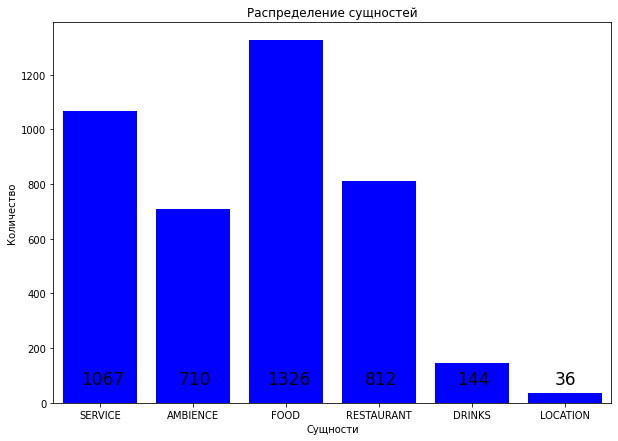

In [42]:
entity_counter = Counter()

for sentence in sentences:
    for target in sentence.targets:
        entity_counter.update([target.category.split('#')[0]])
            
labels = [x for x in entity_counter.values()]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
#ax.grid('on', zorder=0)
ax.bar(entity_counter.keys(), entity_counter.values(), color='#0000ff', zorder=5)
plt.xlim(left=-0.5, right=5.5)
for i, v in enumerate(labels):
    ax.text(x=i-0.05*len(str(labels[i]))-0.005, 
            y=70, 
            s=labels[i], 
            fontsize=17,
            #color='black' if i==3 else 'white',
            zorder=10,)
plt.xlabel('Сущности')
plt.ylabel('Количество')
plt.title('Распределение сущностей');

### Attribute

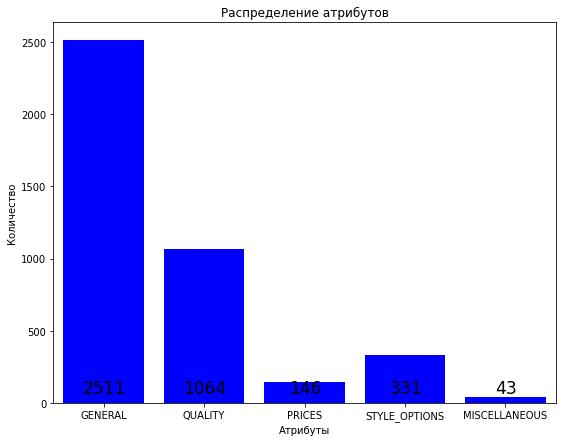

In [43]:
attribute_counter = Counter()

for sentence in sentences:
    for target in sentence.targets:
        attribute_counter.update([target.category.split('#')[1]])
            
labels = [x for x in attribute_counter.values()]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 7))
#ax.grid('on', zorder=0)
ax.bar(attribute_counter.keys(), attribute_counter.values(), color='#0000ff', zorder=5)
plt.xlim(left=-0.5, right=4.5)
for i, v in enumerate(labels):
    ax.text(x=i-0.05*len(str(labels[i]))-0.005, 
            y=70, 
            s=labels[i], 
            fontsize=17,
            #color='black' if i==3 else 'white',
            zorder=10,)
plt.xlabel('Атрибуты')
plt.ylabel('Количество')
plt.title('Распределение атрибутов');